In [1]:
%%capture --no-stderr
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [3]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=os.environ["LANGSMITH_API_KEY"]
os.environ["LANGCHAIN_PROJECT"]="pr-virtual-piglet-90"

In [4]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from typing import Annotated, Literal

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

In [6]:
llm.invoke("Hi!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f', 'finish_reason': 'stop', 'logprobs': None}, id='run-c18c0558-c361-4ca9-8b6e-6e6582ee1800-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

We're going to create agents that will be able to search the internet and write and execute code for us!

In [7]:
tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

Creating an agent `node`. This node will be used to represent agents in the graph state

In [8]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

## Create agent supervisor
This agent uses function calling to choose the next worker node or finish processing.

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. Only route coding requests to the Coder."
    " All non-coding requests are to be routed to the Researcher."
)
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

Using `.partial` creates a new ChatPromptTemplate with some input variables already filled in. This is a LangChain specific implementation of the `.partial` method of the `functools` library.

In [10]:
def supervisor_agent(state):
    """This is the supervisor node
    
    It just picks the next agent to process and decides when the work is completed"""
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

## Construct graph

In [11]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

This will be the `state` input to each node in the graph. The annotation tells the graph that new messages will always be added to the current states. The `next` field indicates where to route to next

In [12]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

Create research agent and the research agent node
> Note the use of `partial` to fill in the arguments of the function of interest.

In [13]:
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(
    agent_node,
    agent=research_agent,
    name="Researcher" #must match the name in the 'members' list above
)

Create code execution agent
> Note that this performs code execution on your computer! In production you'll need to create a sandboxed environment for this

In [14]:
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

A StateGraph is a graph whose nodes communicate by reading and writing to a shared state. It's the overarching graph class of the Langgraph library.
> Here we add human-in-the-loop options by creating breakpoints in the graph. We do this by adding the argument `interrupt_before` during the `.compile()` step.

In [15]:
workflow = StateGraph(AgentState)

## Add nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

## Add edges
### We want our workers to always report back to our supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

### The supervisor then fills in the 'next' field in the graph state for routing
conditional_map = {k:k for k in members}
conditional_map['FINISH'] = END
workflow.add_conditional_edges(
    "supervisor", lambda x: x['next'],
    conditional_map
)

### Connect entrypoint to supervisor
workflow.add_edge(START, "supervisor")

## Add memory - this creates chat history of the graph in an in-memory SQLite database
memory = MemorySaver()

## Compile
### We interrupt before the code execution just to ensure that we're not doing anything cray
graph = workflow.compile(
    interrupt_before=["Coder"], 
    checkpointer=memory
)

Here's what our graph looks like!

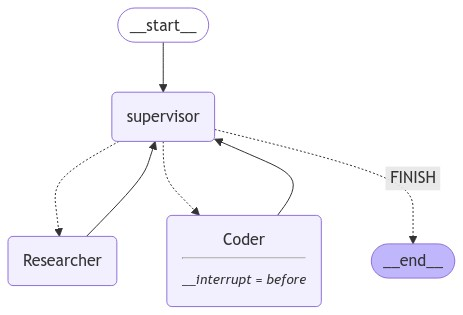

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Let's do some research into the future of generative AI!

In [43]:
thread = {"configurable": {"thread_id": "1"}, "recursion_limit": 5} #for memory

You'll notice that there appears to be a duplication - this is just because the supervisor first invokes the state, passes it to another agent that invokes the state again. Once this agent is done the supervisor invokes the state yet again to determine if more routing is needed or we can just end.

In [44]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(content="Is generative AI just a gimmick? Does it have any quantifiable business value?")
        ]
    },
    thread,
    stream_mode = "values"
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================
Name: Researcher

Generative AI is not merely a gimmick; it has demonstrable business value across various sectors. Here are some key insights:

1. **Business Value**: According to Gartner, organizations that are early adopters of generative AI are leveraging it to enhance their competitive edge. They are focusing on use cases that improve existing processes, differentiate their offerings, and even transform their business models. Generative AI is seen as a tool to increase revenue, reduce costs, improve productivity, and manage risks effectively. For instance, it can automate tasks, genera

In [45]:
graph_state = graph.get_state(thread)

In [46]:
graph_state.values['messages']

[HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={}, id='abba1569-23a5-45da-bbb7-d6793908f975'),
 HumanMessage(content='Generative AI is not merely a gimmick; it has demonstrable business value across various sectors. Here are some key insights:\n\n1. **Business Value**: According to Gartner, organizations that are early adopters of generative AI are leveraging it to enhance their competitive edge. They are focusing on use cases that improve existing processes, differentiate their offerings, and even transform their business models. Generative AI is seen as a tool to increase revenue, reduce costs, improve productivity, and manage risks effectively. For instance, it can automate tasks, generate content, and provide insights that were previously time-consuming to obtain.\n\n2. **Applications Across Industries**: Generative AI has applications in numerous fields, including customer support, mar

And we have chat history!

In [47]:
from IPython.display import display, Markdown

display(Markdown(graph_state.values['messages'][-1].content))

Generative AI is not merely a gimmick; it has demonstrable business value across various sectors. Here are some key insights:

1. **Business Value**: According to Gartner, organizations that are early adopters of generative AI are leveraging it to enhance their competitive edge. They are focusing on use cases that improve existing processes, differentiate their offerings, and even transform their business models. Generative AI is seen as a tool to increase revenue, reduce costs, improve productivity, and manage risks effectively. For instance, it can automate tasks, generate content, and provide insights that were previously time-consuming to obtain.

2. **Applications Across Industries**: Generative AI has applications in numerous fields, including customer support, marketing, finance, healthcare, and product design. It can create original content, such as text, images, and even software code, which can streamline operations and enhance customer experiences. For example, it can be used to generate medical images, synthesize data to mitigate bias, and improve chatbot performance.

3. **Quantifiable Impact**: Research from McKinsey indicates that generative AI could significantly impact various business functions, particularly those with high operational costs. The technology is expected to drive productivity improvements and cost savings, making it a valuable investment for businesses.

4. **Concerns and Challenges**: Despite its potential, there are concerns regarding privacy and the ethical use of data, which may hinder some organizations from fully embracing generative AI. Additionally, the technology's ability to produce errors or "hallucinations" can pose risks if not managed properly.

5. **Future Potential**: The economic potential of generative AI is substantial, with estimates suggesting it could contribute between $10 and $15 trillion to the global economy by 2030. This highlights its transformative potential across various sectors.

In summary, generative AI is far from being just a gimmick; it offers quantifiable business value and has the potential to reshape industries by enhancing efficiency, creativity, and decision-making processes.

## Write code to do stuff!

In [48]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content= "Write python code to calculate the remainder of 15/2"
            )
        ]
    },
    thread, 
    stream_mode='values'
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Write python code to calculate the remainder of 15/2
================================ Human Message =================================

Write python code to calculate the remainder of 15/2


Tada it has stopped! Let's apply a state update

In [49]:
state = graph.get_state(thread)

In [50]:
state.values['messages'][-1]

HumanMessage(content='Write python code to calculate the remainder of 15/2', additional_kwargs={}, response_metadata={})

This is indeed our message. Let's update the state!

In [51]:
graph.update_state(
    thread,
    {
        "messages": [HumanMessage(
            content="No, actually write python code to print 'hello world!'"
        )]
    }
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef97925-3315-6a56-8007-c4cc78c15d22'}}

### Check if state has been updated!

In [52]:
new_state = graph.get_state(thread).values

In [53]:
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================
Name: Researcher

Generative AI is not merely a gimmick; it has demonstrable business value across various sectors. Here are some key insights:

1. **Business Value**: According to Gartner, organizations that are early adopters of generative AI are leveraging it to enhance their competitive edge. They are focusing on use cases that improve existing processes, differentiate their offerings, and even transform their business models. Generative AI is seen as a tool to increase revenue, reduce costs, improve productivity, and manage risks effectively. For instance, it can automate tasks, generate content, and provide insights that were previously time-consuming to obtain.

2. **Applications Across Industries**: Generative AI has applications in numerou

### Invoke graph on revised question
We use the trick of passing `None` to proceed!

In [54]:
for s in graph.stream(None, thread):
    if "__end__" not in s:
        print(s)
        print("----")

{'Coder': {'messages': [HumanMessage(content='The output of the code is: `hello world!`', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [55]:
state = graph.get_state(thread)
display(Markdown(state.values['messages'][-1].content))

The output of the code is: `hello world!`

## We can also run the graph on Langgraph Studio which provides a neat user interface for easier debugging and prototyping!
1. First you're going to have to copy the entire code all the way up to the compile step into a file named `agents.py`
2. Create a `langgraph.json` file which tells the software which script is the entry point, which file contains the environment variables, and which file contains the dependencies.
3. Finally, write a requirements.txt file.
> This is currently only supported on Mac. Be sure to have Docker engine running in the background. Follow the instructions here: [Langgraph Studio GitHub](https://github.com/langchain-ai/langgraph-studio)

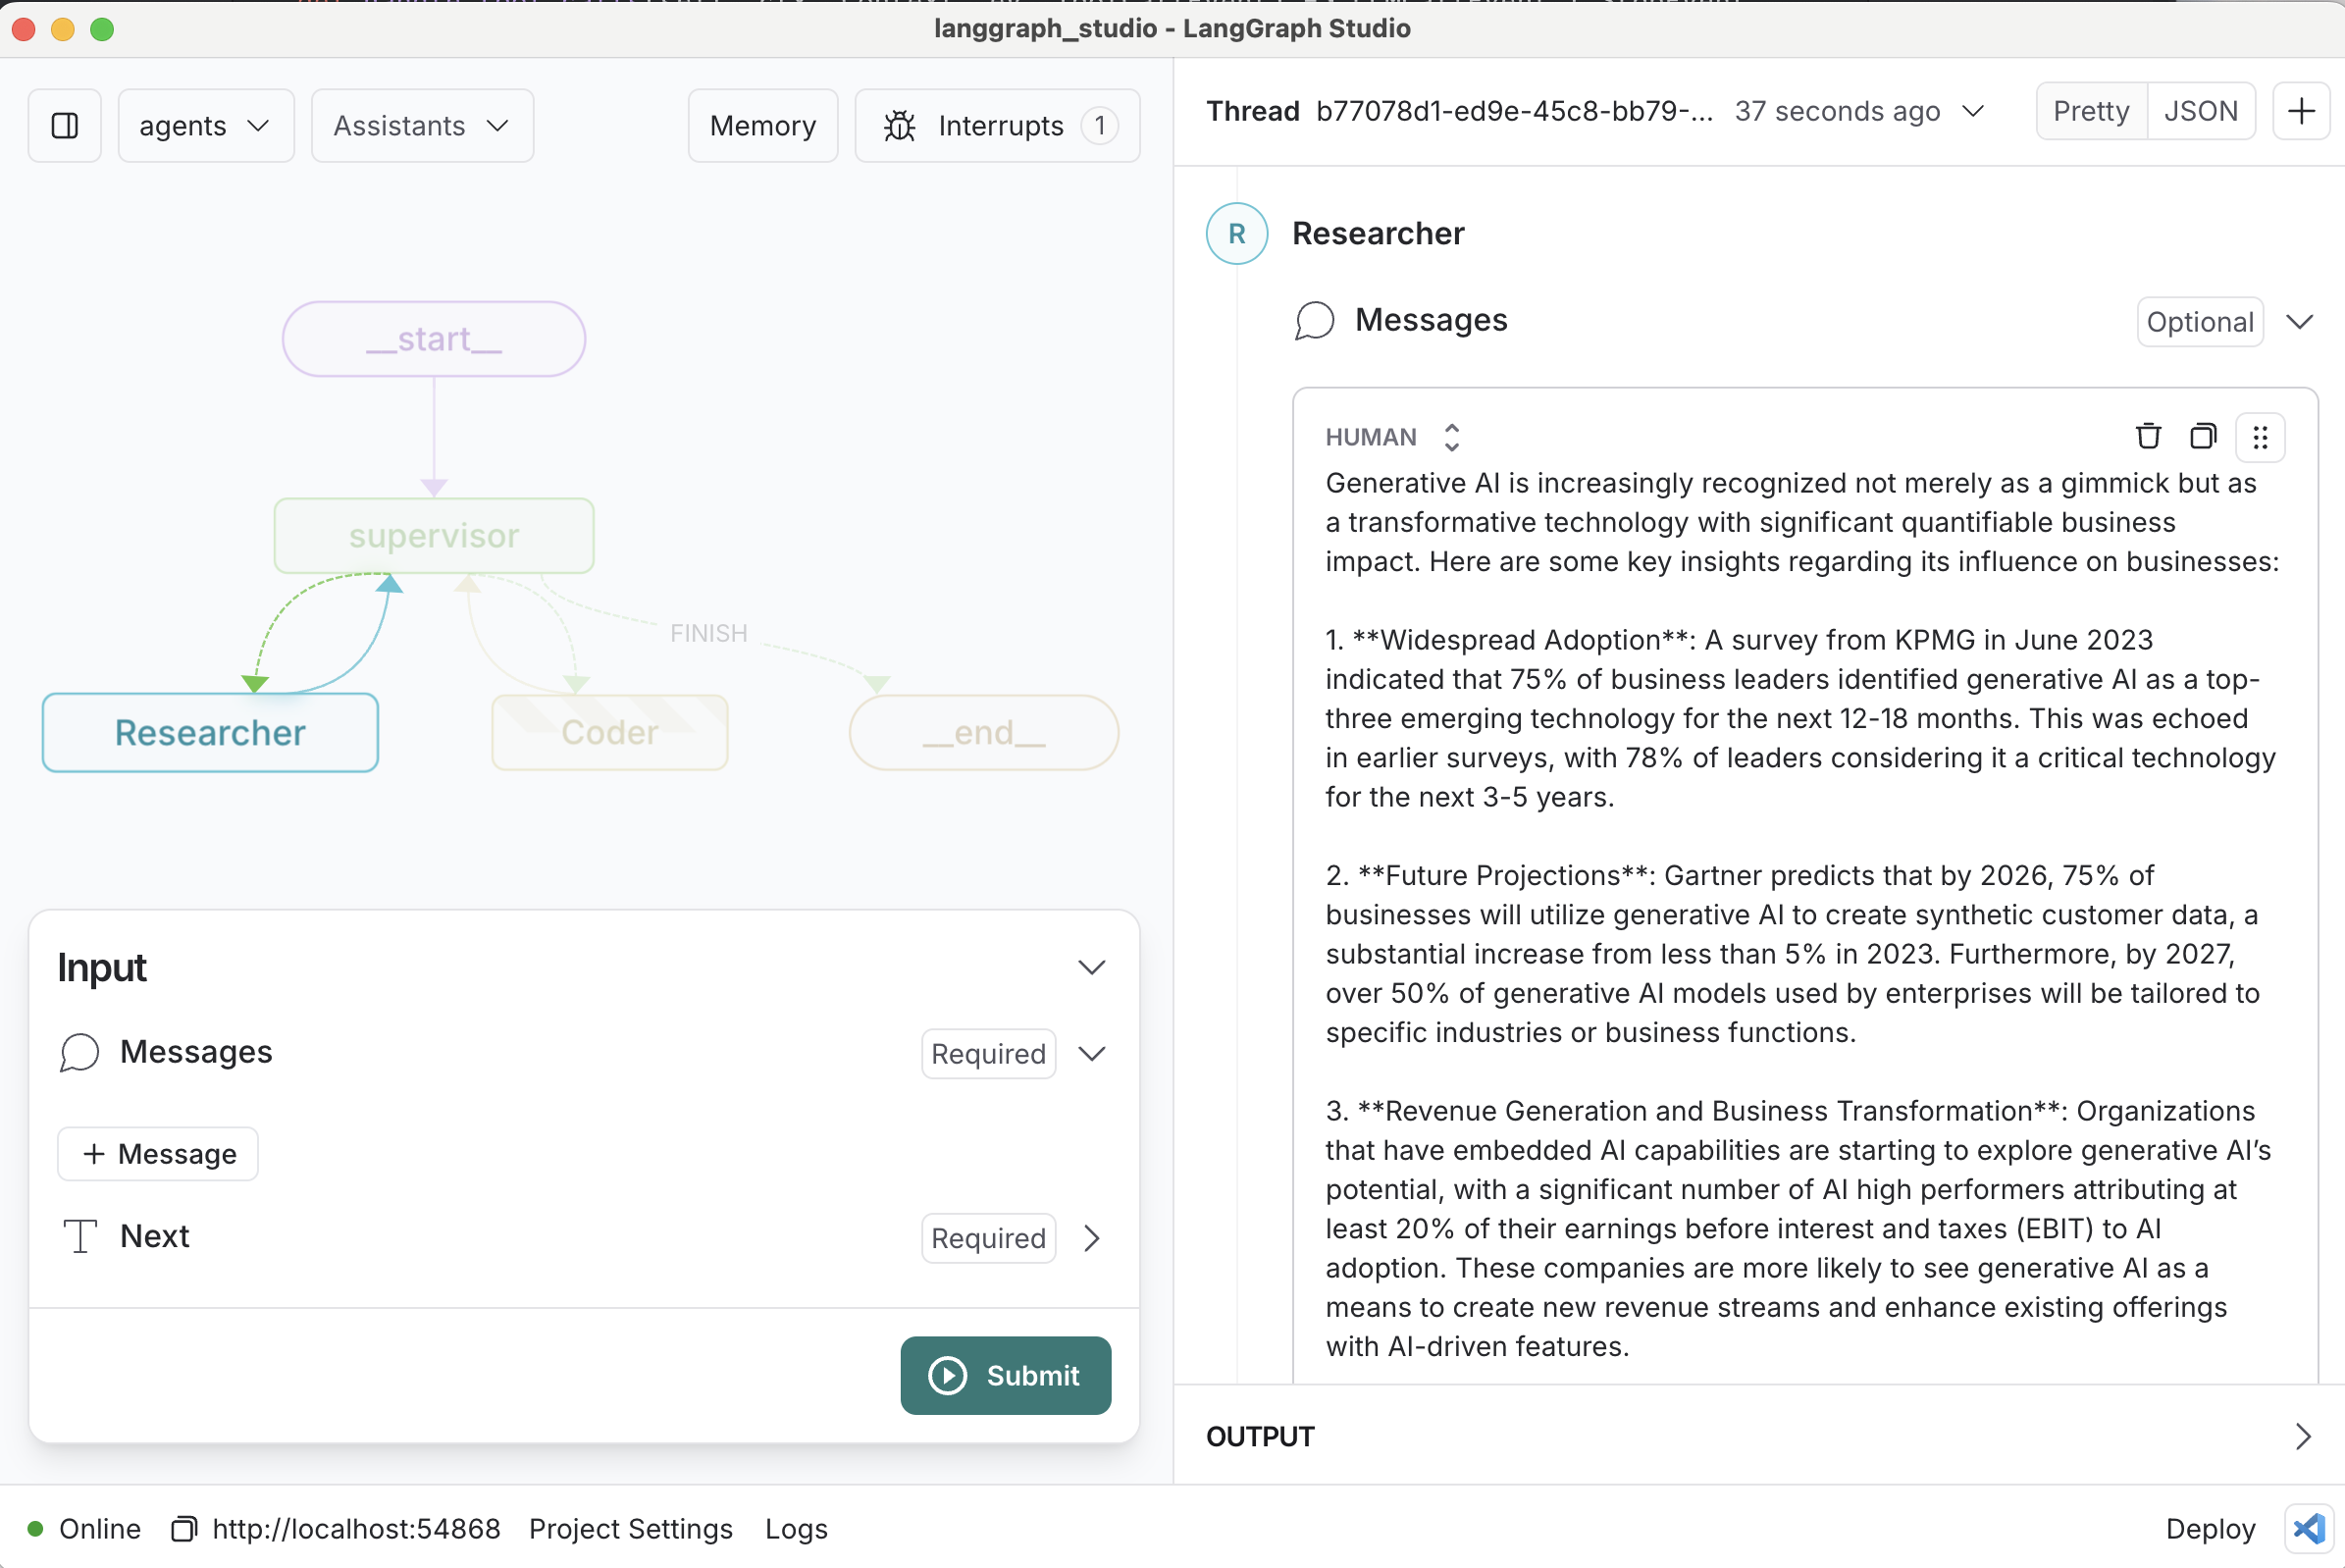

In [57]:
from PIL import Image

Image.open("LanggraphStudio.png")

## Showing LangSmith Traces

#### For Question 1:

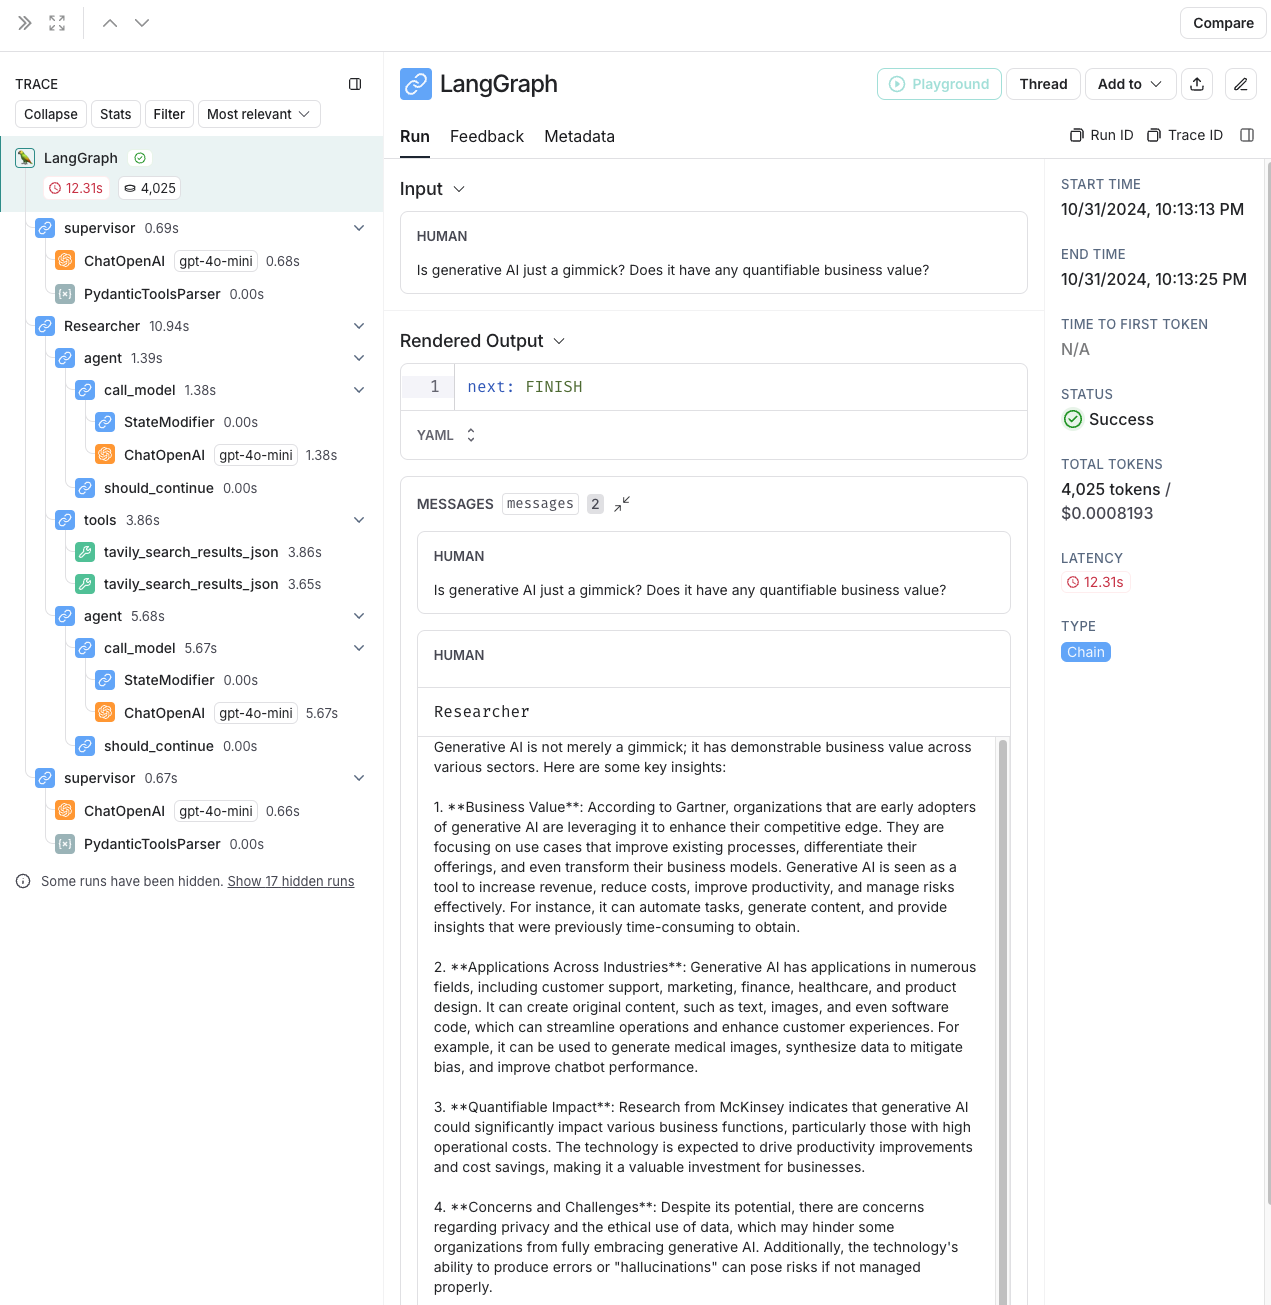

In [58]:
Image.open("LangSmithQ1.png")

#### For Question 2:
When we first asked the question

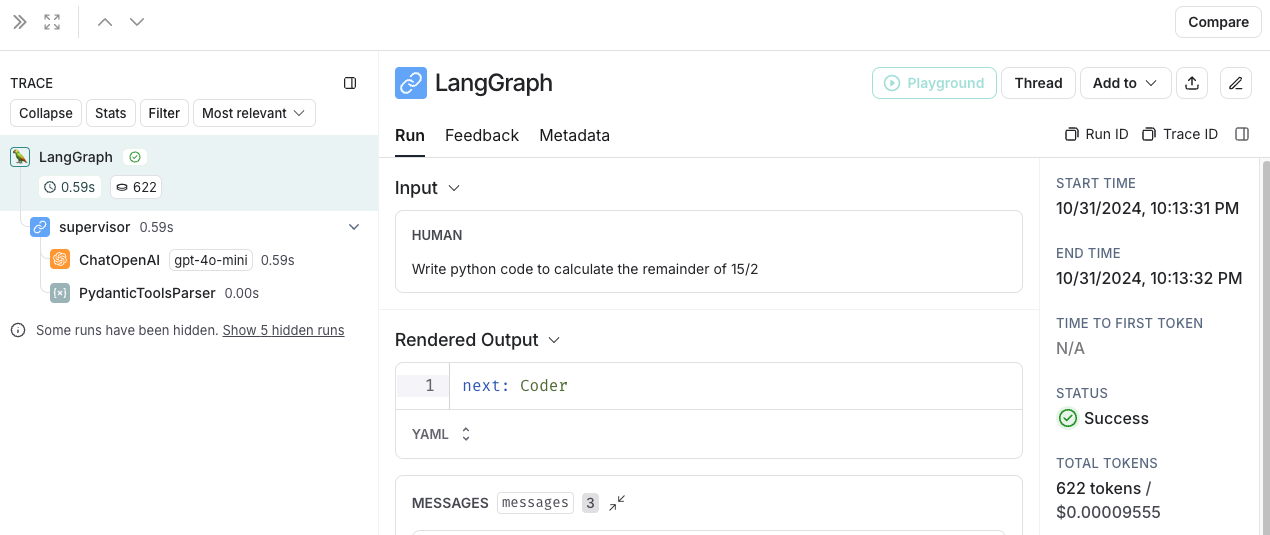

In [61]:
Image.open("LangSmithQ2a.png")

When we updated our question

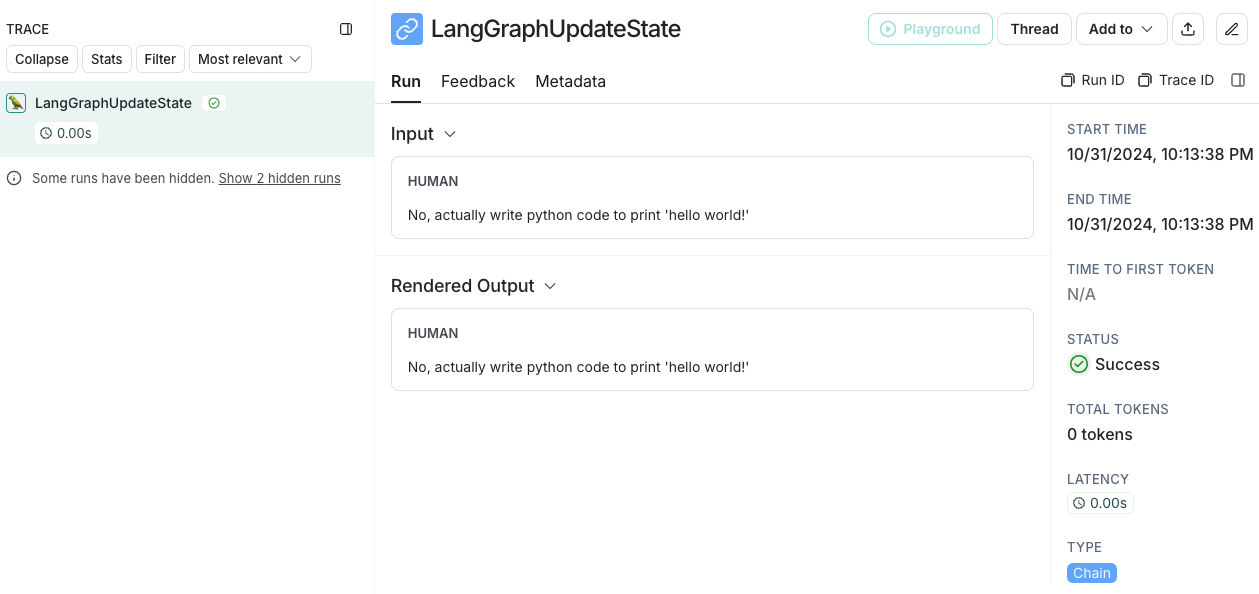

In [59]:
Image.open("LangSmithQ2b.png")

When the graph ran with our updated question

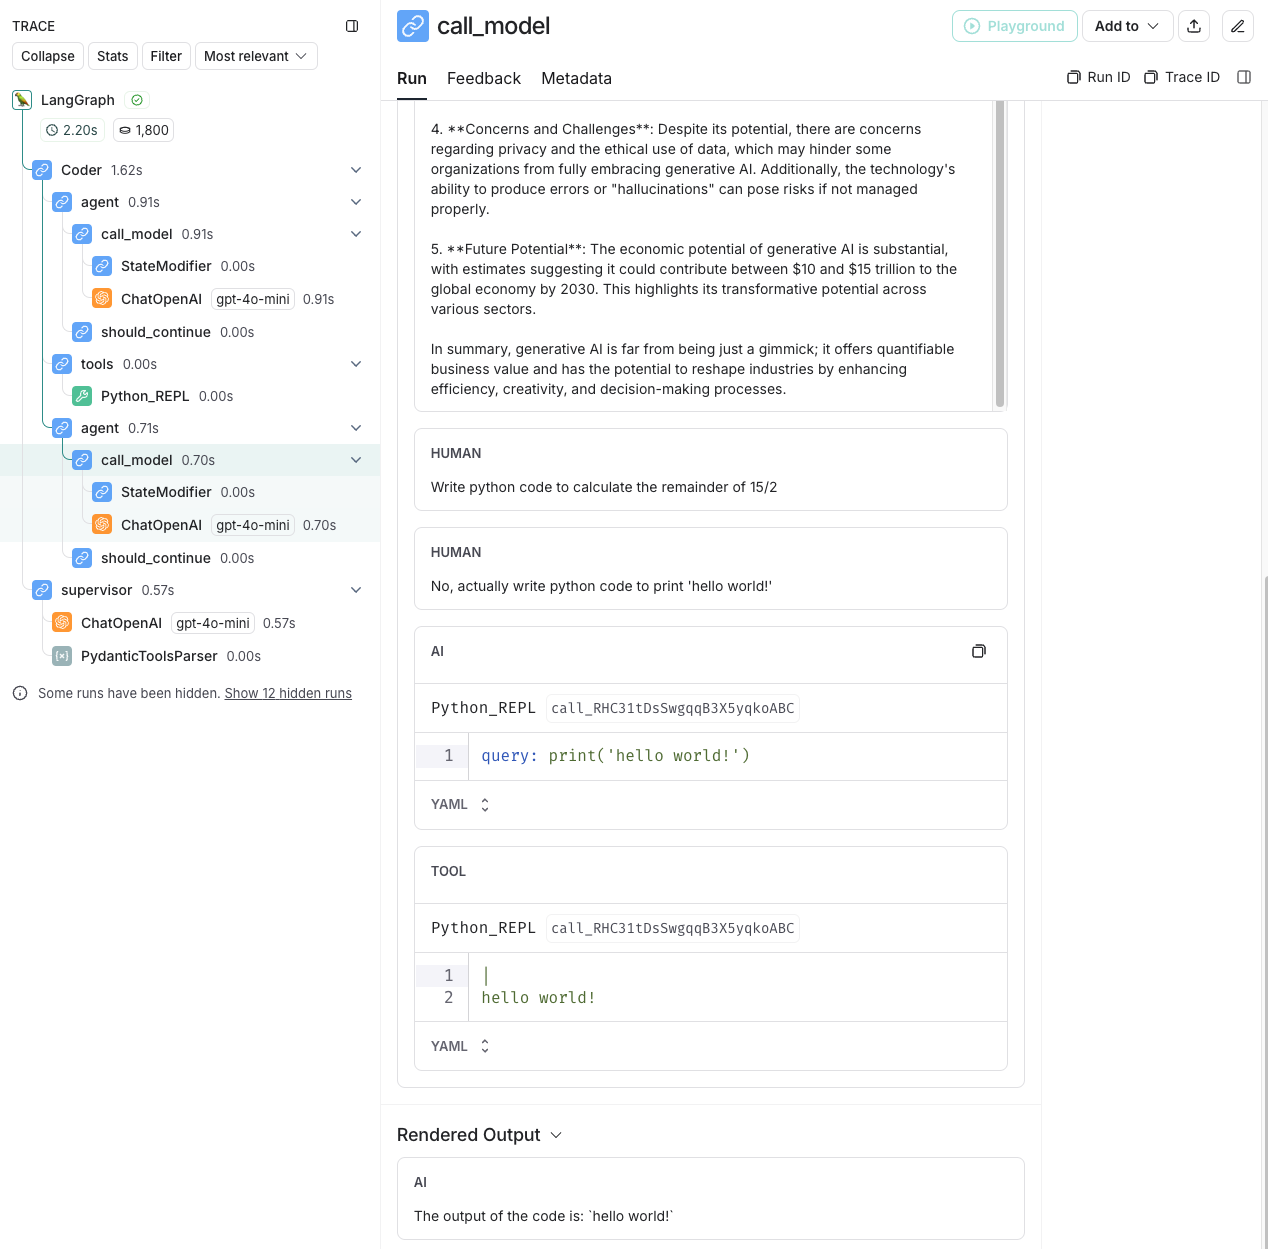

In [60]:
Image.open("LangSmithQ2c.png")